<img src="https://www.luxonis.com/logo.svg" width="400">

# Training a Custom Leaf Segmentation Model

## 🌟 Overview
In this tutorial, we'll go through the process of training a customized segmentation model. We'll first create a model, set up the training configuration, and then use it to train our own NN model. We'll also validate the performance of our model, export it, and make it ready for deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️installation)
- [🗃️ Data Preparation](#data-preparation)
    - [🧐 Parsing the Data](#parsing-the-data)
- [🏋️‍♂️ Training](#️️training)
    - [🎨 Customizations](#customizations)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)

<a name="️installation"></a>

## 🛠️ Installation


The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train), a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality and an easy way of creating and managing computer vision datasets called `LuxonisDataset`.



In [ ]:
%pip install -q luxonis-train>=0.3.6

If you're running on Google Colab's GPU, you may need to restart the session after installing `luxonis-train`.

<a name ="data-preparation"></a>

## 🗃️ Data Preparation

<a name ="parsing-the-data"></a>

### 🧐 Parsing the Data

We will create the `LuxonisDataset` from [roboflow's leaf segmentation dataset](https://universe.roboflow.com/giovi/leaf-segmentation-uxlob/dataset/4) using the `LuxonisTrain` parser option. Specifically, we'll configure the following in our training configuration YAML file:

```yaml
loader:
  params:
    dataset_name: "leafs_dataset"
    dataset_dir: "roboflow://giovi/leaf-segmentation-uxlob/4/coco"
```

For this setup to function properly, we need to set the `ROBOFLOW_API_KEY`. This can be done by creating an account on Roboflow and copying the API key.

In [ ]:
%env ROBOFLOW_API_KEY=YOUR_API_KEY_HERE

# ⚠️ Important: Replace 'YOUR_API_KEY_HERE' with your actual Roboflow API key
# You can find your API key in your Roboflow account settings

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="customizations"></a>

### 🎨 Customizations

We will create a custom UNET architecture for our leaf segmentation task. Although we could use existing segmentation models from `LuxonisTrain` (for instance, the [SegmentationModel config](https://github.com/luxonis/luxonis-train/blob/main/configs/segmentation_light_model.yaml) that uses predefined model described [here](https://github.com/luxonis/luxonis-train/tree/8cc82963f8b2d025e379a6549c2c3c648371a3f7/luxonis_train/config/predefined_models#segmentationmodel)) and are optimized to be fast and accurate, this customization tutorial demonstrates how to integrate different architectures into `LuxonisTrain` with minimal effort.

To utilize the `LuxonisML` parsed dataset and incorporate our UNET model into the [LuxonisTrain framework](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#customizations), we will write a UNET that can be registered as a `BaseHead`. For more examples of registering nodes in Luxonis-Train, refer to the detailed [examples](https://github.com/luxonis/luxonis-train/tree/main/examples#nodes).

Since we want to provide a hands-on example of how to integrate custom components into `LuxonisTrain`—allowing seamless use of parsed datasets and various configuration parameters—we will:

### 1. Custom UNET Model Architecture
**Implement the UNET model as two connected components:**

1. **UNetEncoder**: Inherit from `BaseNode` to create the encoder part
   - Responsible for feature extraction and creating skip connections
   - Returns features that will be passed to the decoder

2. **UNetDecoder**: Inherits from `BaseHead` and serves as the model's final output component. As a `BaseHead` derivative, this decoder enables:
    - **Integration with training infrastructure** - Direct attachment of:
        - Loss functions for optimization
        - Metrics for evaluation
        - Visualizers for result inspection

- **Framework integration** - Define essential class-level attributes:
  - `task`: Designates the component for segmentation tasks
  - `parser`: Specifies the conversion method for NN archive deployment

The decoder is architecturally responsible for progressive upsampling of features, incorporating skip connections from the encoder, and generating the final segmentation prediction map. 

For additional implementation details and attributes , refer to the `LuxonisTrain` [examples](https://github.com/luxonis/luxonis-train/tree/main/examples#nodes).


### 2. Custom Loss Function
**Create a custom loss function** by inheriting from `BaseLoss`, specifying the class-level attribute `supported_tasks`.

In [3]:
import torch
import torch.nn as nn
from torch import Tensor

from luxonis_train.nodes.blocks import UpBlock
from luxonis_train import BaseHead, BaseNode, BaseLoss
from luxonis_train import Tasks


class UNetEncoder(BaseNode):
    """UNet encoder with skip connections."""
    
    def __init__(self, depth: int = 4, base_channels: int = 64, **kwargs):
        """
        Args:
            depth (int): Number of downsampling stages.
            base_channels (int): Number of channels in the first convolution block.
            **kwargs: Additional arguments for BaseNode.
        """
        super().__init__(**kwargs)
        
        self.depth = depth
        self.base_channels = base_channels
        
        # Build the Encoder
        self.encoders = nn.ModuleList()
        in_ch = self.in_channels
        for i in range(depth):
            out_ch = base_channels * (2 ** i)
            self.encoders.append(self._conv_block(in_ch, out_ch))
            in_ch = out_ch
            
        # Bottleneck/Bridge
        self.bottleneck = self._conv_block(in_ch, in_ch * 2)
    
    def forward(self, x: Tensor) -> list[Tensor]:
        # Encoder forward pass
        skip_connections = []
        for enc in self.encoders:
            x = enc(x)
            skip_connections.append(x)
            x = nn.functional.max_pool2d(x, 2)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Return bottleneck output as first element followed by skip connections
        return [x] + skip_connections
    
    def _conv_block(self, in_channels: int, out_channels: int) -> nn.Module:
        """Basic 2-convolution block."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


class UNetDecoder(BaseHead):
    """UNet decoder that uses skip connections from the encoder."""
    
    task = Tasks.SEGMENTATION # Specifies the task that this head is used for.
    parser = "SegmentationParser" # Parser to use when converting model to NN Archive
    
    def __init__(self, depth: int = 4, base_channels: int = 64, **kwargs):
        """
        Args:
            depth (int): Number of upsampling stages.
            base_channels (int): Number of base channels.
            **kwargs: Additional arguments for BaseHead.
        """
        super().__init__(**kwargs)
        
        self.depth = depth
        self.base_channels = base_channels
        
        # Calculate bottleneck channels
        bottleneck_channels = base_channels * (2 ** depth)
        in_ch = bottleneck_channels
        
        # Build the Decoder
        self.up_blocks = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        
        for i in reversed(range(depth)):
            out_ch = base_channels * (2 ** i)
            self.up_blocks.append(
                UpBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    upsample_mode="conv_transpose"
                )
            )
            self.decoder_convs.append(self._conv_block(out_ch * 2, out_ch))
            in_ch = out_ch
        
        # Final Convolution Layer
        self.final_conv = nn.Conv2d(in_ch, self.n_classes, kernel_size=1)
    
    def forward(self, input: list[Tensor]) -> Tensor:
        # Extract bottleneck and skip connections from input list
        x = input[0]  # First element is bottleneck output
        skip_connections = input[1:]  # Remaining elements are skip connections
        skip_connections = skip_connections[::-1]  # Reverse for decoder (deepest to shallowest)
        
        # Decoder Forward
        for i, up in enumerate(self.up_blocks):
            x = up(x)  # Upsample
            skip = skip_connections[i]
            # Concatenate skip-connection
            x = torch.cat([x, skip], dim=1)
            x = self.decoder_convs[i](x)
        
        # Final Segmentation
        return self.final_conv(x)
    
    def _conv_block(self, in_channels: int, out_channels: int) -> nn.Module:
        """Basic 2-convolution block."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
    
    # For NN Archive conversion we need to provide the custom head configuration
    def get_custom_head_config(self) -> dict:
        return {
            "is_softmax": False,
        }


class MyBCEWithLogitsLoss(BaseLoss):
    # The `supported_tasks` attribute is used to specify
    # which tasks this loss is compatible with.
    supported_tasks = [Tasks.SEGMENTATION, Tasks.CLASSIFICATION]

    def __init__(self, 
                 weight=None,  # Manual rescaling weight for each class
                 reduction='mean',  # 'none', 'mean', or 'sum'
                 pos_weight=None,  # Weight for positive examples (helps with class imbalance)
                 **kwargs):
        super().__init__(**kwargs)
        self.criterion = nn.BCEWithLogitsLoss(
            weight=weight,
            reduction=reduction,
            pos_weight=pos_weight
        )

    def forward(self, predictions: Tensor, target: Tensor) -> Tensor:
        return self.criterion(predictions, target)

<a name="️configuration"></a>

### ⚙️ Configuration

### Configuration File Structure

In the configuration file, we define several critical sections:

#### Model Section
Here we configure our custom UNet architecture by specifying:
- The custom UNet model
- Associated loss functions
- Evaluation metrics
- Visualization components

#### Loader Section
This section defines the data pipeline where `dataset_dir` should point to one of the parser-supported formats documented in the [LuxonisTrain data directory documentation](https://github.com/luxonis/luxonis-train?tab=readme-ov-file#-data-directory). The parser seamlessly handles the conversion from your raw data to model-compatible formats. Alternatively, you can use an existing dataset in the `LuxonisDataset` format. Learn more about how to easily create such datasets [here](https://github.com/luxonis/luxonis-ml/blob/main/luxonis_ml/data/README.md).

#### Trainer Section
The [trainer section](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md#trainer) allows you to configure:
- Training hyperparameters (learning rate, batch size, etc.)
- Data augmentation strategies
- Optimization algorithms and learning rate schedulers
- [Callbacks](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks) such as GPU utilization metrics, exponential moving average (EMA), and more

#### Hyperparameter Optimization

This example demonstrates the ease of implementing custom nodes with LuxonisML and LuxonisTrain. For production use cases requiring optimal performance, you can also leverage the built-in [hyperparameter tuner](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-tuning). This eliminates the need for manual trial-and-error and helps discover the most effective model configuration.

In [ ]:
%%writefile leaf_segmentation_model_config.yaml
model:
  name: CustomUNet
  nodes:
    - name: UNetEncoder
      params:
        depth: 4
        base_channels: 32
    
    - name: UNetDecoder
      params:
        depth: 4
        base_channels: 32
      
      inputs:
        - UNetEncoder
      
      losses:
        - name: MyBCEWithLogitsLoss
      
      metrics:
        - name: JaccardIndex
          is_main_metric: true

      visualizers:
        - name: SegmentationVisualizer

loader:
  params:
    dataset_name: "leafs_dataset"
    dataset_dir: "roboflow://giovi/leaf-segmentation-uxlob/4/coco"

trainer:
  precision: "16-mixed"
  preprocessing:
    train_image_size: [384, 384]
    keep_aspect_ratio: true
    normalize:
      active: true
    augmentations:
    - name: Rotate
      params:
        limit: 10
        p: 0.5
        border_mode: 0
        value: [0, 0, 0]
    - name: Perspective
      params:
        scale: [0.04, 0.08]
        keep_size: true
        pad_mode: 0
        pad_val: 0
        mask_pad_val: 0
        fit_output: false
        interpolation: 1
        always_apply: false
        p: 0.5
    - name: Affine
      params:
        scale: 1
        translate_percent: 0
        rotate: 0
        shear: 10
        interpolation: 1
        mask_interpolation: 0
        cval: 0
        cval_mask: 0
        mode: 0
        fit_output: false
        keep_ratio: false
        rotate_method: largest_box
        always_apply: false
        p: 0.4
    - name:  HorizontalFlip
      params:
        p: 0.5
      
  batch_size: 16
  epochs: &epochs 100
  n_workers: 4
  validation_interval: 10
  n_log_images: 20

  callbacks:
    - name: TestOnTrainEnd
    - name: ExportOnTrainEnd

  optimizer:
    name: AdamW
    params:
      lr: 0.0005
      weight_decay: 0.0001


  scheduler:
    name: CosineAnnealingLR
    params:
      T_max: *epochs
      eta_min: 0.0001


Leveraging Luxonis-Train's flexible customization framework, you can create multiple interconnected custom nodes in your model architecture for various tasks such as detection, instance keypoint detection, instance segmentation, classification, segmentation, OCR, unsupervised anomaly detection, and more. You can even create custom loaders and architectures for unusual tasks. For a detection model, it would look like:

- A custom backbone node
- A custom neck node
- A custom detection head node
- A custom loss for the detection head

**The possibilities are endless**. For full details on how to register additional nodes, refer to the previously mentioned [examples](https://github.com/luxonis/luxonis-train/tree/main/examples#nodes).

Each architectural component in the model serves a different purpose and therefore inherits from the appropriate base class:

- Backbones and necks should inherit from `BaseNode`
- Heads should inherit from `BaseHead` (which itself extends `BaseNode`) 
- Loss functions should inherit from `BaseLoss`

Once all your custom components are defined, you simply configure the model to connect the backbone to the neck and the neck to the head in the YAML file:

```yaml
model:
  name: CustomDetectionModel
  nodes:
    - name: CustomDetectionBackbone
      params:
        ...
    - name: CustomDetectionNeck
      params:
        ...
      inputs:
        - CustomDetectionBackbone
    - name: CustomDetectionHead
      params:
        ...
      inputs:
        - CustomDetectionNeck
      losses:
        - name: CustomDetectionLoss
          params:
            ...
      metrics:
        - name: MeanAveragePrecision
      visualizers:
        - name: BBoxVisualizer
```

While developing custom nodes, it's always beneficial to understand the exact shapes of the data yielded by the loader. For this information, you should consult the [loaders](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/loaders) section in the Luxonis-Train repository. Also, information about the expected input/output formats can be found in the [visualizer](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/attached_modules/visualizers) documentation, which also explains the data shapes expected by metrics (as metrics typically use the same data format as visualizers).

While these advanced architectures showcase the framework's flexibility, for this tutorial we will continue with our custom UNET model defined previously. This focused approach allows us to demonstrate the core principles of model customization without unnecessary complexity

<a name ="train"></a>

### 🦾 Train


To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it.

 **Note**: LuxonisTrain also supports all these commands through its CLI ([documentation here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. For custom nodes, simply provide the `--source` flag with the path to where your custom components are initialized:

 ```bash
 luxonis_train --source custom_components.py train --config leaf_segmentation_model_config.yaml
 ```

We won't use the CLI for this tutorial, but feel free to use it in your own projects.

In [ ]:
from luxonis_train import LuxonisModel

config_path = "leaf_segmentation_model_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is an image segmentation task, we use the Jaccard index metric to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [ ]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

The purpose of this tutorial is to demonstrate how easy it is to implement custom nodes with luxonis-train and to train any model you choose. The model's performance can be further improved by first finding the best hyperparameters using the [tuner](https://github.com/luxonis/luxonis-train?tab=readme-ov-file#-tuning) and retraining. 

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-style: italic">        CustomUNet        </span>
┏━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃<span style="color: #800080; text-decoration-color: #800080; font-weight: bold"> Name         </span>┃<span style="color: #800080; text-decoration-color: #800080; font-weight: bold"> Value   </span>┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━┩
│<span style="color: #800080; text-decoration-color: #800080"> JaccardIndex </span>│<span style="color: #c0c0c0; text-decoration-color: #c0c0c0"> 0.81811 </span>│
└──────────────┴─────────┘
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold">               Test metric                </span>┃<span style="font-weight: bold">               DataLoader 0               </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│<span style="color: #008080; text-decoration-color: #008080">                test/loss                 </span>│<span style="color: #800080; text-decoration-color: #800080">           0.24979379773139954            </span>│
│<span style="color: #008080; text-decoration-color: #008080"> test/loss/CustomUNet/MyBCEWithLogitsLoss </span>│<span style="color: #800080; text-decoration-color: #800080">           0.24979379773139954            </span>│
│<span style="color: #008080; text-decoration-color: #008080">   test/metric/CustomUNet/JaccardIndex    </span>│<span style="color: #800080; text-decoration-color: #800080">            0.818109929561615             </span>│
└──────────────────────────────────────────┴──────────────────────────────────────────┘
</pre>

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [ ]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_beans_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_leafs_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

Now, let's visualize one of the predictions.

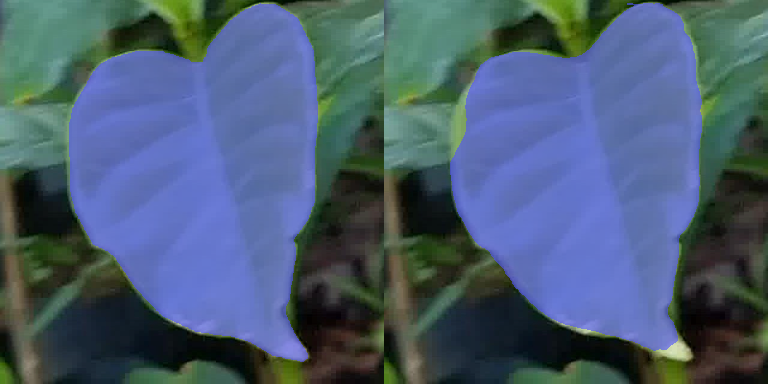

In [19]:
from IPython.display import Image
Image(filename='infer_results_leafs_model/CustomUNet_SegmentationVisualizer_13.png')

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [ ]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv==0.4.0

We will use the `ModelConverter` Python API, which leverages our [`HubAI`](https://hub.luxonis.com) platform to perform model conversion in the background. To get started, you'll need to create an account on `HubAI` and obtain your team’s API key.

Model conversion can be done via either the CLI or the Python API — here, we'll use the latter. For more information, see the [online usage section](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage) of the documentation.

The call below creates a new model card within your team on `HubAI`, uploads the model file and metadata, then performs cloud-side conversion to the selected target platform (e.g., [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)). Once completed, the converted model is automatically downloaded to your device.

For HubAI-specific conversion parameters, refer to the [online conversion section](https://github.com/luxonis/modelconverter/tree/e6a3478ba47d8f92d4d60217f2aee0f4f468cb14/modelconverter/hub#online-conversion) of the ModelConverter documentation. Platform-specific parameters are also documented there.


In [ ]:
NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"
HUBAI_API_KEY = "<YOUR_HUBAI_API_KEY>"

In [ ]:
from modelconverter.hub import convert


converted_model = convert.RVC2(
    api_key=HUBAI_API_KEY,
    path=NN_ARCHIVE_PATH,
    name="LeafSegmentationModel",
    description="Leaf Segmentation Model",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

We have successfully converted our trained model for an RVC2 device!